In [37]:
import os
#os.chdir('..') # go back to the root directory

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import json
import glob
import random
from evaluation.neuroprobe.config import *
# from evaluation.neuroprobe.braintreebank_subject import BrainTreebankSubject as Subject
from subject.braintreebank import BrainTreebankSubject as Subject
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'

# all possible pairs of (subject_id, trial_id)
all_subject_trials = [(1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (6, 0), (6, 1), (6, 4), (7, 0), (7, 1), (8, 0), (9, 0), (10, 0), (10, 1)]

In [99]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

base_path = os.path.join(ROOT_DIR, 'localization')
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [t[0] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

def plot_hemisphere_axis(electrodes, colors=None, ax=None, hemisphere="left", title=None, vmin=0, vmax=0.1):
    '''
    electrodes is a dict of format {<subject>: [<electrode>]}
    '''
    if colors is None: c = 'white'
    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img)
    elif hemisphere=="right":
        ax.imshow(right_hem_img)
    
    ax.axis('off')
    assert hemisphere in ["left", "right"]
    hem_index = 1 if hemisphere=="left" else 0

    plot_title = f'{hemisphere} hemisphere'
    if title: plot_title += f' {title}'
   
    all_x, all_y, all_colors = [], [], []
    for s in electrodes:
        for e in electrodes[s]:
            x = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['X'])
            y = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['Y'])
            if (len(x) == 0 or len(y) == 0) and hemisphere == "left":
                print(f"Warning: No coordinates found for subject {s} and electrode {e} in {hemisphere} hemisphere")
            if len(x) == 0 or len(y) == 0:
                continue
            
            assert len(x) == len(y) == 1, f"For subject {s} and electrode {e}, x: {x}, y: {y}"

            all_x += x
            all_y += y
            all_colors += [colors[e]]
    print(all_colors)
    
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    all_colors = np.array(all_colors)
    # Sort points by color value so lower values appear on top
    sort_idx = np.argsort(all_colors)[::-1]
    sc = ax.scatter(all_x[sort_idx], all_y[sort_idx], c=all_colors[sort_idx], vmin=vmin, vmax=vmax, s=100, edgecolors='black', cmap='viridis_r')
    
def plot_hemispheres_separately(electrodes, ax1, ax2, colors=None, vmin=0, vmax=0.1):
    plot_hemisphere_axis(electrodes, colors=colors, ax=ax1, hemisphere="right", vmin=vmin, vmax=vmax)
    plot_hemisphere_axis(electrodes, colors=colors, ax=ax2, hemisphere="left", vmin=vmin, vmax=vmax)

In [86]:
attention_matrices = np.load('runs/data/andrii0_wd0.0001_dr0.1_rTEMP/key_electrodes/model_epoch100/key_electrodes_btbank3_1_onset_attention.npy', allow_pickle=True)
x = np.array(attention_matrices.item()['analysis_results']).mean(axis=0)
cmap = plt.cm.viridis(x[0][0, 1:])

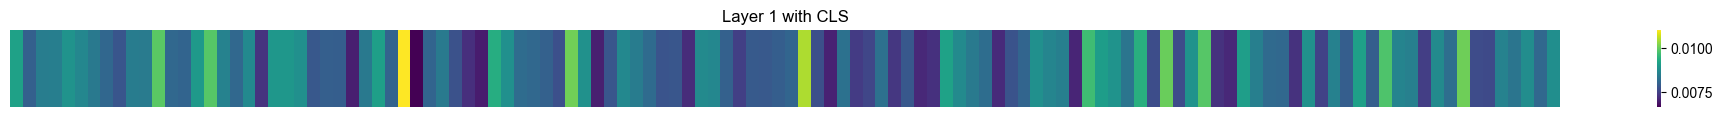

In [93]:
import seaborn as sns
plt.figure(figsize=(25, 1))
sns.heatmap(x[1][0:1, 1:], cmap='viridis', annot=False, fmt='.3f', square=False,
            xticklabels=False, yticklabels=False)
plt.title(f'Layer {1} with CLS')
plt.show()

[]
['#32b57a', '#472b7a', '#433c84', '#3b508a', '#2f6a8d', '#414186', '#3f4587', '#462f7c', '#472676', '#69cc5b', '#404387', '#39548b', '#3f4788', '#24848d', '#3d4b89', '#3d4a89', '#d2e11b', '#433b83', '#404387', '#24868d', '#39558b', '#424085', '#481d6f', '#33608d', '#472777', '#414286', '#462d7c', '#472676', '#433c84', '#404487', '#481e70', '#472878', '#414186', '#443982', '#433a83', '#46317e', '#2f698d', '#46307d', '#3a528b', '#46317e', '#482374', '#3d4a89', '#5ec961', '#472676', '#472676', '#30688d', '#46307d', '#424085', '#472777', '#472a79', '#2d6f8e', '#443982', '#30678d', '#433b83', '#440154', '#482374', '#472b7a', '#472a79', '#3e4989', '#481d6f', '#453681', '#482071', '#482071', '#3c4d8a', '#433b83', '#3c4e8a', '#443982', '#453681', '#453681', '#482273', '#472c7b', '#38578c', '#3e4888', '#1e978a', '#228a8d', '#25828e', '#46307d', '#2f6a8d', '#472c7b', '#32628d', '#472777', '#38578c', '#472c7b', '#404487', '#482172', '#424085', '#404387', '#481a6c', '#3a538b', '#2c718e', '#3f47

/tmp/ipykernel_3045091/1658750751.py:80: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  sc = ax.scatter(all_x[sort_idx], all_y[sort_idx], c=all_colors[sort_idx], vmin=vmin, vmax=vmax, s=100, edgecolors='black', cmap='viridis_r')


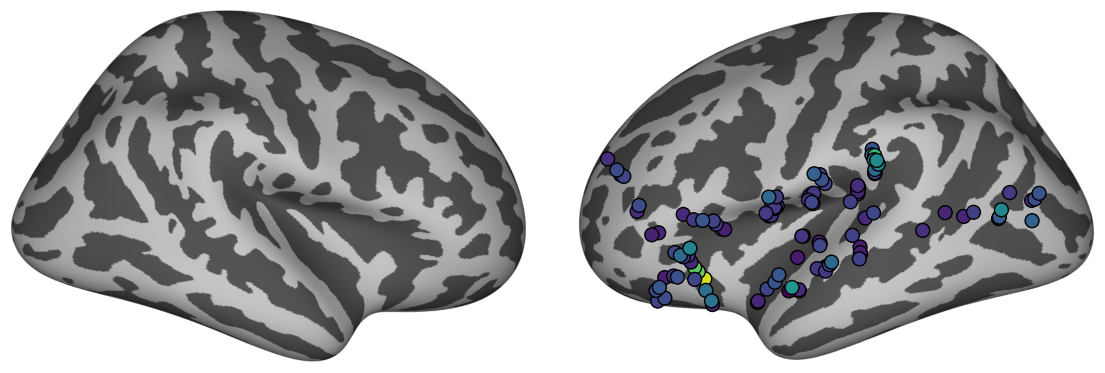

In [100]:
vmin, vmax = 0, 1
fig, axes = plt.subplots(1, 2, figsize=(14, 9),
                        gridspec_kw={'wspace': 0.1})

# Collect all electrodes across subjects
all_electrodes = {}
for subject_id in [3]:
    subject_class = Subject(subject_id, cache=False)
    all_electrodes[f"sub_{subject_id}"] = subject_class.electrode_labels

attention_matrix_electrodes = {
    'sub_3': attention_matrices.item()['electrode_labels'][1:]
}

from matplotlib.colors import Normalize

# Create white colors for all electrodes
colors = {}
norm = Normalize(x[0][0, 1:].min(), x[0][0, 1:].max())
cmap = plt.cm.viridis
colors_rgba = cmap(norm(x[0][0, 1:]))
for i, electrode_label in enumerate(attention_matrices.item()['electrode_labels']):
    if electrode_label == 'CLS':
        continue

    color = colors_rgba[attention_matrices.item()['electrode_labels'].index(electrode_label)-1]
    # Convert RGBA array to hex color string
    color_str = '#{:02x}{:02x}{:02x}'.format(
        int(color[0] * 255),
        int(color[1] * 255), 
        int(color[2] * 255)
    )
    colors[electrode_label] = color_str

# Plot all subjects on single pair of hemispheres
plot_hemispheres_separately(attention_matrix_electrodes, axes[0], axes[1], colors=colors)

# plt.savefig('figures/hemispheres_electrodes.pdf', bbox_inches='tight', dpi=300)

In [45]:
total_n_electrodes = sum([len(all_electrodes[f"sub_{subject_id}"]) for subject_id in range(1, 11)])
print("Total number of electrodes: ", total_n_electrodes)

KeyError: 'sub_1'

NameError: name 'SAVE_SPEECH_SELECTIVITY_DATA_DIR' is not defined

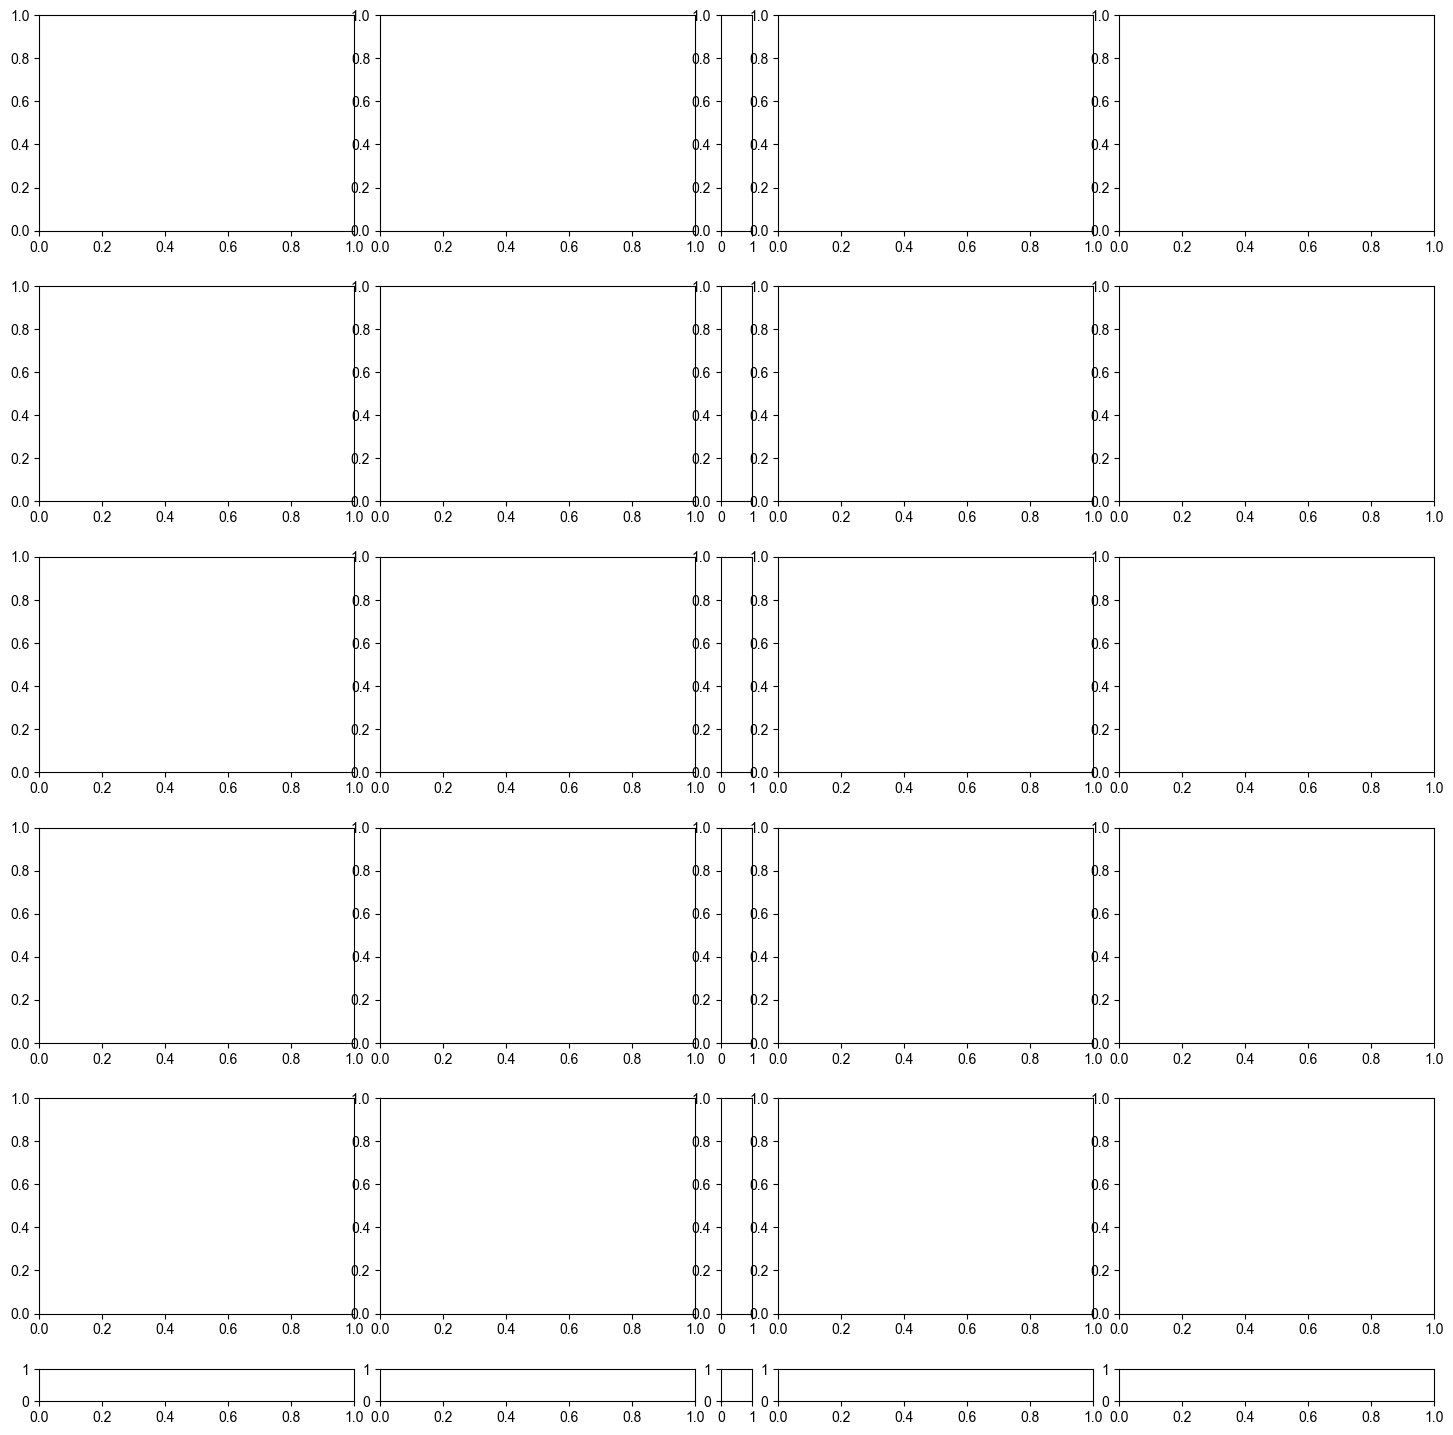

In [34]:
vmin, vmax = 0, 0.1
fig, axes = plt.subplots(6, 5, figsize=(18, 18), 
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.3,
                                   'width_ratios': [1, 1, .1, 1, 1], 'height_ratios': [1, 1, 1, 1, 1, .15]}) 
for subject_id in range(1, 11):
    row = (subject_id - 1) // 2
    if (subject_id - 1) % 2 == 0: col1, col2 = 0, 1
    else: col1, col2 = 3, 4
    subject_class = Subject(subject_id, cache=False)
    n_electrodes = len(subject_class.electrode_labels)
    n_sessions = len([trial_id for (_subject_id, trial_id) in all_subject_trials if _subject_id == subject_id])
    colors = np.ones(n_electrodes)

    if os.path.exists(SAVE_SPEECH_SELECTIVITY_DATA_DIR + f"/subject{subject_id}_stats.json"):
        subject_metadata = json.load(open(SAVE_SPEECH_SELECTIVITY_DATA_DIR + f"/subject{subject_id}_stats.json", "r"))
        electrode_p_values = subject_metadata['electrode_p_values']
        electrode_p_values_corrected = subject_metadata['electrode_p_values_corrected']
        fdr_threshold = subject_metadata['fdr_threshold']
        fdr_level = subject_metadata['fdr_level']
        colors = np.array(electrode_p_values_corrected)
    colors = {label: colors[i] for i, label in enumerate(subject_class.electrode_labels)}

    electrodes = {f"sub_{subject_id}": subject_class.electrode_labels}
    plot_hemispheres_separately(electrodes, axes[row, col1], axes[row, col2], colors=colors, vmin=vmin, vmax=vmax)
    # Add text label above each pair of axes
    axes[row, col1].set_title(f'Subject {subject_id}   (N={n_sessions} sessions; N={n_electrodes} electrodes)', 
                              loc='left', fontsize=20, pad=10, weight='bold')
# Remove axes from middle column
for row in range(5):
    axes[row, 2].set_visible(False)
for col in range(5):
    axes[5, col].set_visible(False)

# Add custom colorbar in middle column
cbar_ax = fig.add_subplot(axes[5, 0])
# Adjust the position and width of the colorbar axes
cbar_ax.set_position([cbar_ax.get_position().x0+0.01, 
                      cbar_ax.get_position().y0,
                      cbar_ax.get_position().width * 2,
                      cbar_ax.get_position().height / 1.5])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cbar = plt.colorbar(scalar_mappable, cax=cbar_ax, orientation='horizontal')
cbar.ax.text(0.105, 0.18, 'FDR-corrected p-value', rotation=0, fontsize=20)
cbar.ax.tick_params(labelsize=20, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.set_ticks(np.arange(0, 0.15, 0.05))
cbar_ax.set_visible(True)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/language_localizer.pdf', bbox_inches='tight', dpi=300)


In [18]:
subject_mapping = {"m00183": "sub_1",
                   "m00184": "sub_2",
                   "m00185": "sub_3",
                   "m00187": "sub_4",
                   "m00188": "sub_5",
                   "m00191": "sub_6",
                   "m00192": "sub_7",
                   "m00193": "sub_8",
                   "m00194": "sub_9",
                   "m00195": "sub_10",
}
electrodes = {"electrodes": ["F2Ia9_m00185", "LT3a3_m00184", "LT1bIb6_m00184", "T1cIe6_m00185", "T3aHb9_m00183", "LT3a4_m00184", "RT1aIa2_m00184", "RT1bIb7_m00184", "T1aIb1_m00183", "F3cId8_m00183", "LT2aA4_m00184", "LT3d7_m00184", "T1cIe9_m00185", "T1Id5_m00191", "LT3cHb4_m00184", "LT1c4_m00184", "LT3a2_m00184", "T1bId4_m00195", "RT2aA9_m00184", "T1bIc4_m00183", "T2bHa9_m00183", "RT2b1_m00184", "T1cIf11_m00183", "LT2aA14_m00184", "T1aIb7_m00183", "RT1c8_m00184", "T3aHb12_m00183", "T2d6_m00183", "RT1aIa4_m00184", "F3d5_m00185", "F2Ia4_m00185", "F3c9_m00185", "F3bIaOFb9_m00183", "T3aHb10_m00183", "RT3aHa11_m00184", "LT3d5_m00184", "T3bOT8_m00183", "T3aHb6_m00183", "T2c8_m00183", "T3bOT10_m00183", "RT1bIb8_m00184", "RT3aHa5_m00184", "RT3bHb12_m00184", "LT3cHb12_m00184", "F3c10_m00185", "T1cIf10_m00183", "T1bIc2_m00183", "RT1aIa5_m00184", "RT1bIb6_m00184", "T1aIb3_m00183", "P2a4_m00185", "RT2aA4_m00184", "T3bOT9_m00183", "RT2aA10_m00184", "RT2aA7_m00184", "O1aIb12_m00185", "LT2aA6_m00184", "RT1c7_m00184", "RT3bHb8_m00184", "LT3d6_m00184", "RT3bHb7_m00184", "LT3a7_m00184", "T1aIb5_m00183", "T2c4_m00183", "F3bIaOFb10_m00183", "LT1bIb2_m00184", "F3d2_m00185", "T1cIf14_m00183", "F3aOF2_m00185", "T1aIb2_m00183", "RT1bIb5_m00184", "RT1c2_m00184", "RT1c10_m00184", "F3d10_m00185", "T1cIf8_m00183", "LT1bIb10_m00184", "LT3cHb6_m00184", "T1aIb4_m00183", "LT3bHa6_m00184", "F3c6_m00185", "O1aIb4_m00185", "T1cIf15_m00183", "RT3aHa9_m00184", "F3cId9_m00183", "LT2b5_m00184", "O1bId14_m00185", "LT2aA5_m00184", "RT1aIa3_m00184", "LT3bHa5_m00184", "T2aA8_m00183", "T1aA11_m00188", "O1aIb5_m00185", "RT2b2_m00184", "F3c2_m00185", "RT1c5_m00184", "T1aIb8_m00183", "RT1bIb4_m00184", "LT2b1_m00184", "T1aIc3_m00185", "LT1c3_m00184", "LT1bIb1_m00184", "T1bIc3_m00183", "O1aIb9_m00185", "F3dIe10_m00183", "F3bIaOFb11_m00183", "RT2b3_m00184", "T2bHa10_m00183", "T2aA5_m00183", "T1bIc5_m00183", "O1bId8_m00185", "O1aIb7_m00185", "F3c3_m00185", "P2a3_m00185", "LT1c2_m00184", "LT2b4_m00184", "T1b4_m00185", "F3c5_m00185", "LT2aA1_m00184", "LT2aA8_m00184", "RT1bIb1_m00184", "F3cId10_m00183", "T1cIf5_m00183", "T1bIc8_m00183", "F3bIaOFb4_m00183", "RT3bHb11_m00184", "T1cIe10_m00185", "RT1c1_m00184", "LT3d3_m00184", "T1cIf6_m00183", "F3aOF3_m00185", "T2c7_m00183", "P2a9_m00185", "F3aOFa10_m00183", "RT3aHa10_m00184", "LT1bIb7_m00184", "F3bIaOFb6_m00183", "LT1c6_m00184", "T1cIf13_m00183", "RT2b5_m00184", "LT3cHb5_m00184", "T1bId3_m00195", "LT2aA7_m00184", "LT2aA12_m00184", "T1cIf16_m00183", "LT1bIb4_m00184", "T1b2_m00185", "RT3bHb5_m00184", "RT3aHa14_m00184", "T1aIb6_m00183", "LT1c7_m00184", "F2Ia8_m00185", "RT1aIa7_m00184", "T1cIe8_m00185", "RT1bIb3_m00184", "T1bId6_m00195", "T1cIf12_m00183", "T1cIe12_m00185", "O1aIb10_m00185", "F3cId3_m00183", "T1b3_m00185", "T2bHa11_m00183", "F3d8_m00185", "RT3aHa12_m00184", "RT3aHa13_m00184", "T1bIc7_m00183", "O1aIb6_m00185", "LT1bIb5_m00184", "F2Ia2_m00185", "O1aIb11_m00185", "RT3bHb6_m00184", "T1bIc6_m00183", "LT1bId6_m00187", "F3cId2_m00183", "RT1aIa8_m00184", "F3bIaOFb7_m00183", "F3bIaOFb8_m00183", "LT3bHa7_m00184", "LT1c8_m00184", "RT1c9_m00184", "T2bHa14_m00183", "RT1c4_m00184", "F3bIaOFb15_m00183", "T1aA10_m00188", "O1aIb3_m00185", "T2c5_m00183", "F2Ia11_m00185", "LT3a6_m00184", "LT3bHa14_m00184", "T2aA7_m00183", "RT2aA3_m00184", "RT1c3_m00184", "LT2b3_m00184", "F3c4_m00185", "RT3aHa7_m00184", "T1cIf4_m00183", "LT1bId5_m00187", "LT3a9_m00184", "RT1bIb2_m00184", "LT3d8_m00184", "T1cIe7_m00185", "RT2aA6_m00184", "T1bIc1_m00183", "LT1c5_m00184", "LT2aA9_m00184", "T1aA12_m00188", "LT3bHa8_m00184", "RT3bHb10_m00184", "T2bHa13_m00183", "LT3a5_m00184", "F3c8_m00185", "T1cIe5_m00185", "F3bIaOFb16_m00183", "RT2aA5_m00184", "RT3aHa8_m00184", "RT1aIa1_m00184", "RT1aIa6_m00184", "T1b1_m00185", "T2bHa12_m00183", "F3dIe14_m00183", "T1aA13_m00188", "F3d7_m00185", "T2aA6_m00183", "LT3a1_m00184", "T1Id6_m00191", "RT2aA2_m00184", "F3d9_m00185", "LT3a10_m00184", "LT1bIb9_m00184", "RT2aA1_m00184", "LT3bHa9_m00184", "F3bIaOFb13_m00183", "P2a10_m00185", "RT3aHa6_m00184", "LT3d4_m00184", "F3aOF7_m00185", "RT2b4_m00184", "F2Ia3_m00185", "O1aIb8_m00185", "RT2aA8_m00184", "F3d6_m00185", "LT1bIb3_m00184", "T1aIc2_m00185", "LT1bIb8_m00184", "T1cIe11_m00185"]}
# Restructure electrodes by subject
electrodes_by_subject = {"sub_" + str(i): [] for i in range(1, 11)}

# Reverse mapping from subject code to subject number
reverse_mapping = {v: k for k, v in subject_mapping.items()}

# Process each electrode
for electrode in electrodes["electrodes"]:
    # Extract subject code from electrode name (last part after underscore)
    subject_code = electrode.split("_")[-1]
    
    # Get subject number using reverse mapping
    subject_num = subject_mapping.get(subject_code, None)
    
    if subject_num:
        # Initialize list for this subject if not already present
        if subject_num not in electrodes_by_subject:
            electrodes_by_subject[subject_num] = []
            
        # Add electrode to appropriate subject list
        electrodes_by_subject[subject_num].append(electrode.split("_")[0])

# Sort subjects and electrodes
electrodes_by_subject = dict(sorted(electrodes_by_subject.items()))
for subject in electrodes_by_subject:
    electrodes_by_subject[subject].sort()
electrodes_by_subject.keys()

dict_keys(['sub_1', 'sub_10', 'sub_2', 'sub_3', 'sub_4', 'sub_5', 'sub_6', 'sub_7', 'sub_8', 'sub_9'])

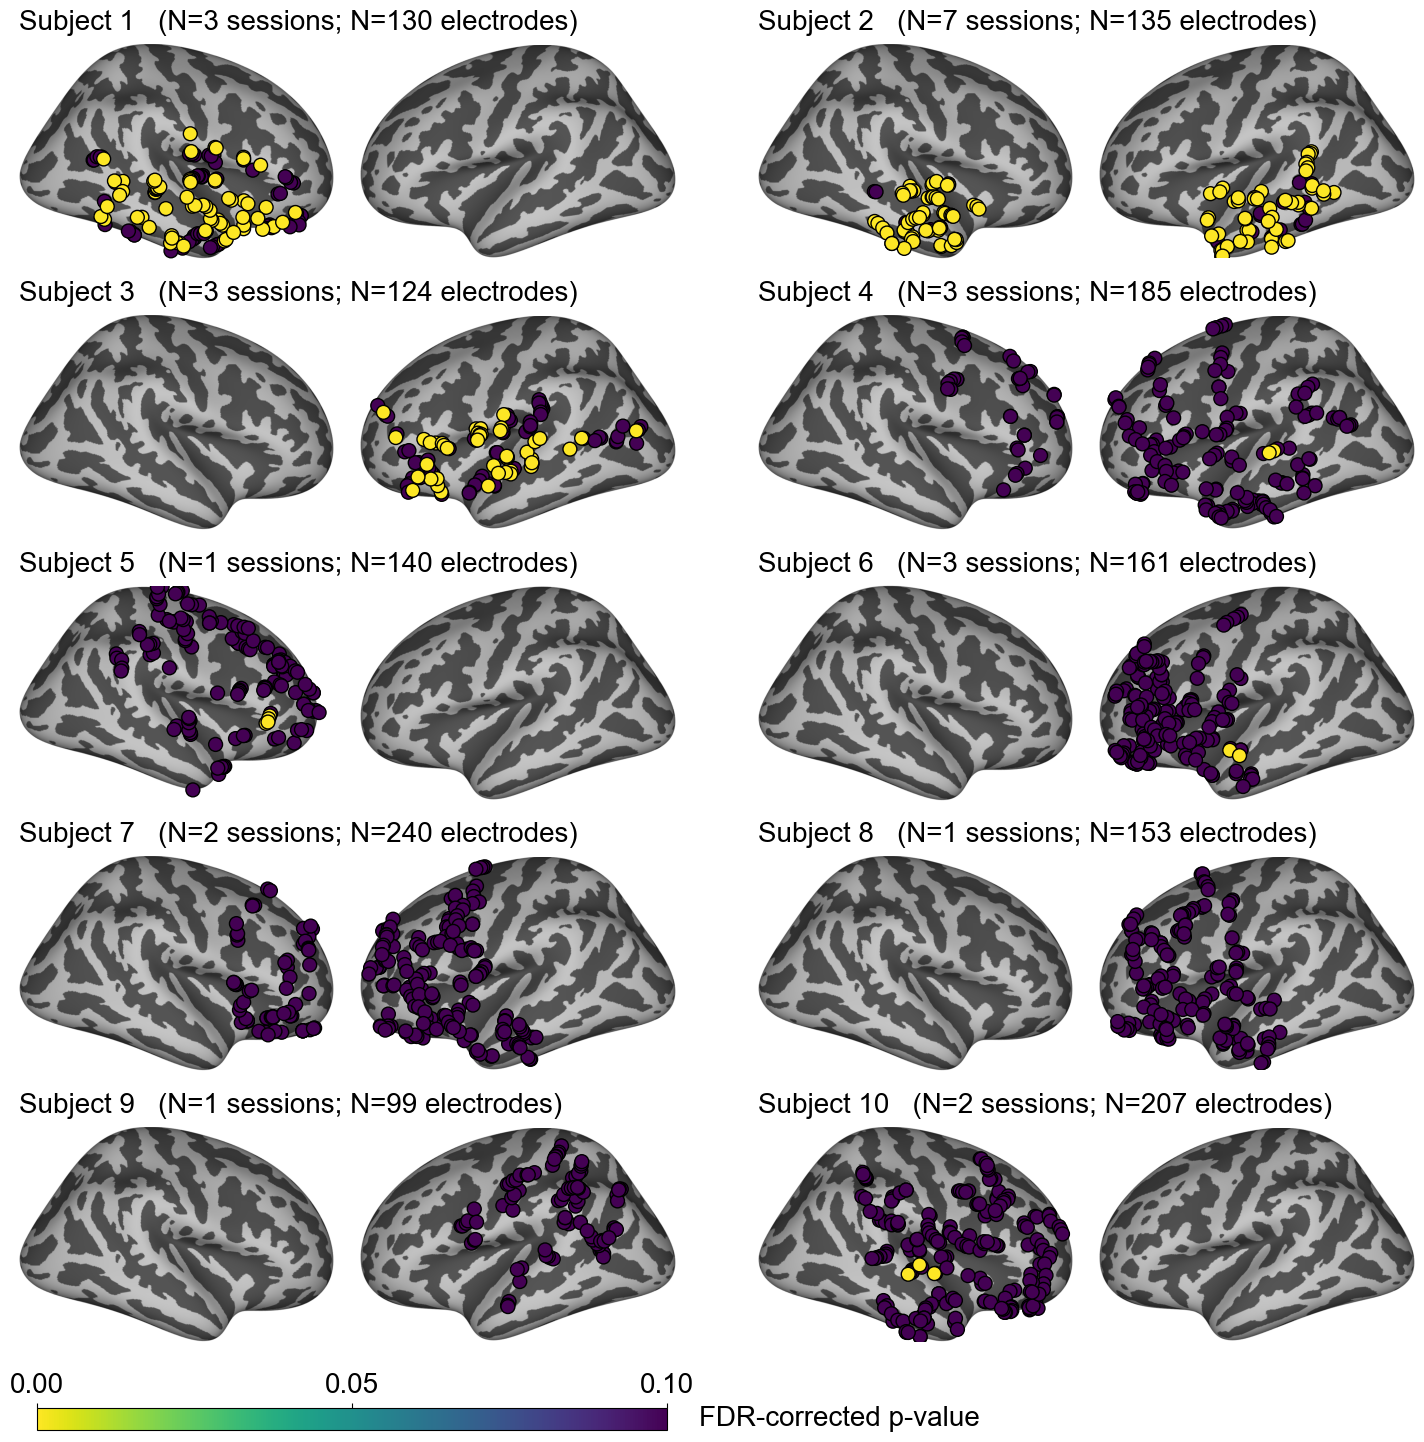

In [19]:
vmin, vmax = 0, 0.1
fig, axes = plt.subplots(6, 5, figsize=(18, 18), 
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.3,
                                   'width_ratios': [1, 1, .1, 1, 1], 'height_ratios': [1, 1, 1, 1, 1, .15]}) 
for subject_id in range(1, 11):
    row = (subject_id - 1) // 2
    if (subject_id - 1) % 2 == 0: col1, col2 = 0, 1
    else: col1, col2 = 3, 4
    subject_class = Subject(subject_id, cache=False)
    n_electrodes = len(subject_class.electrode_labels)
    n_sessions = len([trial_id for (_subject_id, trial_id) in all_subject_trials if _subject_id == subject_id])

    from braintreebank_subject import Subject
    subject = Subject(subject_id, cache=False)
    subject_electrode_stats = []
    for electrode in subject.electrode_labels:
        if electrode in electrodes_by_subject[f"sub_{subject.subject_id}"]:
            subject_electrode_stats.append(0)
        else:
            subject_electrode_stats.append(1)
    colors = np.array(subject_electrode_stats)
    colors = {label: colors[i] for i, label in enumerate(subject_class.electrode_labels)}

    electrodes = {f"sub_{subject_id}": subject_class.electrode_labels}
    plot_hemispheres_separately(electrodes, axes[row, col1], axes[row, col2], colors=colors, vmin=vmin, vmax=vmax)
    # Add text label above each pair of axes
    axes[row, col1].set_title(f'Subject {subject_id}   (N={n_sessions} sessions; N={n_electrodes} electrodes)', 
                              loc='left', fontsize=20, pad=10, weight='bold')
# Remove axes from middle column
for row in range(5):
    axes[row, 2].set_visible(False)
for col in range(5):
    axes[5, col].set_visible(False)

# Add custom colorbar in middle column
cbar_ax = fig.add_subplot(axes[5, 0])
# Adjust the position and width of the colorbar axes
cbar_ax.set_position([cbar_ax.get_position().x0+0.01, 
                      cbar_ax.get_position().y0,
                      cbar_ax.get_position().width * 2,
                      cbar_ax.get_position().height / 1.5])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cbar = plt.colorbar(scalar_mappable, cax=cbar_ax, orientation='horizontal')
cbar.ax.text(0.105, 0.18, 'FDR-corrected p-value', rotation=0, fontsize=20)
cbar.ax.tick_params(labelsize=20, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.set_ticks(np.arange(0, 0.15, 0.05))
cbar_ax.set_visible(True)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/language_localizer_wang_et_al.pdf', bbox_inches='tight', dpi=300)
